<a href="https://colab.research.google.com/github/dyllanesl/AI-EDGE-Project/blob/main/Copy_of_ASL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Restart Runtime
Quick way to restart the runtime

In [ ]:
import os
os._exit(00)



#Install dependencies
Install dependices and necessary libaries

In [1]:
# Install essential libraries
!pip install torch torchvision==0.18.1
!pip install diffusers transformers datasets accelerate
!pip install mediapipe opencv-python
!pip install datasets

# Download the Mediapipe hand landmarker model
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinu

#Load Specific pre-trained diffusion model
From hugging Face Model Hub , this provides an easy way to load and interact with pre-trained diffusion models.

In [92]:
import torch
from torch import nn
from diffusers import UNet2DModel

class ClassConditionedUnet(nn.Module):
    def __init__(self, model_name, num_classes=26, class_emb_size=4, in_channels=3, out_channels=3):
        super().__init__()
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        # Load the pre-trained model without any class conditioning
        self.model = UNet2DModel.from_pretrained(model_name, low_cpu_mem_usage=False, ignore_mismatched_sizes=True)

        # Update the in_channels to include the class embedding size
        self.model.config.in_channels = 3 + class_emb_size

        # Reinitialize the first convolutional layer to match the updated configuration
        old_conv = self.model.conv_in
        self.model.conv_in = nn.Conv2d(
            3 + class_emb_size,
            old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding
        )

        # Initialize the new weights
        with torch.no_grad():
            self.model.conv_in.weight[:, :3, :, :] = old_conv.weight[:, :3, :, :]  # Copy old weights for the first 3 channels
            nn.init.normal_(self.model.conv_in.weight[:, 3:, :, :], 0, 0.02)  # Initialize new weights for the extra channels
            if self.model.conv_in.bias is not None:
                self.model.conv_in.bias = old_conv.bias

    def forward(self, x, t, class_labels):
        bs, ch, w, h = x.shape
        class_cond = self.class_emb(class_labels).view(bs, -1, 1, 1).expand(bs, -1, w, h)
        net_input = torch.cat((x, class_cond), 1)
        return self.model(net_input, t)

    def save_pretrained(self, save_directory):
        self.model.save_pretrained(save_directory)
        torch.save(self.class_emb.state_dict(), f"{save_directory}/class_emb.pth")

    @classmethod
    def from_pretrained(cls, model_name, save_directory, num_classes=26, class_emb_size=4):
        model = cls(model_name, num_classes, class_emb_size)
        model.model = UNet2DModel.from_pretrained(save_directory, low_cpu_mem_usage=False, ignore_mismatched_sizes=True)

        # Ensure the first convolutional layer is correctly reinitialized
        old_conv = model.model.conv_in
        model.model.conv_in = nn.Conv2d(
            3 + class_emb_size,
            old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding
        )

        # Initialize the new weights
        with torch.no_grad():
            model.model.conv_in.weight[:, :3, :, :] = old_conv.weight[:, :3, :, :]  # Copy old weights for the first 3 channels
            nn.init.normal_(model.model.conv_in.weight[:, 3:, :, :], 0, 0.02)  # Initialize new weights for the extra channels
            if model.model.conv_in.bias is not None:
                model.model.conv_in.bias = old_conv.bias

        model.class_emb.load_state_dict(torch.load(f"{save_directory}/class_emb.pth"))
        return model

In [93]:
model_name = "dyllanesl/ASL_Diffusion_Model"  # Example smaller model
#model_name = "google/ddpm-cifar10-32"

# Instantiate the custom class with the pre-trained model configuration
custom_model = ClassConditionedUnet(model_name)

# Move the model to GPU if available
#custom_model.to("cuda")
print(custom_model)

Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ClassConditionedUnet(
  (class_emb): Embedding(26, 4)
  (model): UNet2DModel(
    (conv_in): Conv2d(7, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_proj): Timesteps()
    (time_embedding): TimestepEmbedding(
      (linear_1): Linear(in_features=128, out_features=512, bias=True)
      (act): SiLU()
      (linear_2): Linear(in_features=512, out_features=512, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
     

#Train Model Here
In this cell we upload the csv file to then use to combine with our images then push the final dataset combined to HuggingFace
#Only Use to into new Data


In [ ]:
# Convert the dataset to a pandas DataFrame
# Load the CSV file with labels
from google.colab import files
import pandas as pd

# Upload the CSV file
uploaded = files.upload()

csv_filename = list(uploaded.keys())[0]

labels_df = pd.read_csv("ASL_Sheet.csv")



Saving ASL_Sheet.csv to ASL_Sheet.csv


#Pull images from hugging face
Here we get our images from a current dataset that only has images to prepare to combine with the labels
###Only for new data

In [ ]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("ascar17/ASLPics")

print(dataset)
print(dataset["train"][0])

Resolving data files:   0%|          | 0/78 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/78 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 78
    })
})
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x300 at 0x7CB6983C04F0>}


#Testing
Here we see if this was done correctly by trying to display the first image to check if this was successful, while also displaying the label column to further confirm this

In [ ]:
#Import io and PIL
from io import BytesIO
from PIL import Image

#Print the first item in the dataset
image = dataset["train"][0]['image']
image

#display
labels_df['label']

#Push to Hugging Face
Here we upload our secret token, must use your own
###Only for new data


In [ ]:
from google.colab import userdata
from huggingface_hub import login
login(token = userdata.get('ASL_Token'))


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


#Install datasets/Combine images and labels
Here we finally combine our images and labels through a dictonary

In [ ]:
print(Dataset.from_dict({'image': dataset["train"]['image'], 'label': labels_df['label']})
)

NameError: name 'dataset' is not defined

##Checking our dataset

In [ ]:
from datasets import Dataset
#combine the images with the labels
image_dataset = Dataset.from_dict({'image': dataset["train"]['image'], 'label': labels_df['label']})
#Display
image_dataset

NameError: name 'dataset' is not defined

#Final Push to huggingface
Push to hugging face new dataset to save it and have it there :)
Only for new data

In [ ]:
#Send it to huggingface
image_dataset.push_to_hub("ascar17/FinalDataAsl")

NameError: name 'image_dataset' is not defined

#Check for a pretrained model
Here we see if we should begin training from a previous training or if we should begin from a base pulled from hugging face

In [116]:
import os
model_name = "dyllanesl/ASL_Diffusion_Model"
#model_name = "google/ddpm-cifar10-32"  # Example smaller model

# Check if a saved model exists
save_directory = "/content/fine_tuned_class_conditioned_unet"
if os.path.exists(save_directory):
    print('WE use a custom model')
    custom_model = ClassConditionedUnet.from_pretrained(model_name, save_directory)
else:
    print('WE use a default model')
    custom_model = ClassConditionedUnet(model_name)

# Move the model to GPU if available
#custom_model.to("cuda")

WE use a default model


Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#Pull our dataset

In [120]:
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from datasets import load_dataset

dataset = load_dataset('ascar17/FinalDataAsl')

#Preprocess our dataset
Put it into pixels and also add the labels to the images

In [121]:
from datasets import load_dataset
from torchvision.transforms import Compose, ColorJitter, Resize, ToTensor, Normalize
from PIL import Image

# Load the dataset
dataset = load_dataset("ascar17/FinalDataAsl", split='train')

# Define preprocessing steps
preprocess = Compose([
    Resize((128, 128)),
    ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),  # Add color jittering
    ToTensor(),
    Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

def preprocess_function(example):
    try:
        image = example['image']
        image = image.convert("RGB")
        image = preprocess(image)
        label = example['label']
        label = ord(label) - ord('A')
        return {"pixel_values": image, "label": label}
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

# Apply the preprocessing function to the dataset
processed_dataset = dataset.map(preprocess_function, remove_columns=["image"])

# Remove any None entries from the dataset
processed_dataset = processed_dataset.filter(lambda x: x is not None and x['pixel_values'] is not None)

# Check if 'pixel_values' column exists
print(f"Processed dataset length: {len(processed_dataset)}")

if len(processed_dataset) > 0:
    print(processed_dataset[0])

# Format the dataset for PyTorch if it contains data
if len(processed_dataset) > 0:
    processed_dataset.set_format(type='torch', columns=['pixel_values', 'label'])
    # Inspect the preprocessed dataset
    print(processed_dataset[0])
else:
    print("Processed dataset is empty.")


Processed dataset length: 78
{'label': 0, 'pixel_values': [[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

#Begin Training
Here we actually train the model and save a few of the generating of the images to see where the progress is coming from

In [127]:
from torch.optim import AdamW
from torch.utils.data import DataLoader
from accelerate import Accelerator
from torch.cuda.amp import autocast, GradScaler
import torchvision
import torch
import os
import matplotlib.pyplot as plt

output_dir = "/content/generated_images"
os.makedirs(output_dir, exist_ok=True)

# DataLoader for training data
train_dataloader = DataLoader(processed_dataset, batch_size=1, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the custom model
custom_model = ClassConditionedUnet("dyllanesl/ASL_Diffusion_Model", num_classes=26, class_emb_size=4)
custom_model.to(device)  # Move model to the correct device

# Initialize Accelerator
accelerator = Accelerator()

# Initialize the optimizer / Changes how fast it learns
optimizer = AdamW(custom_model.parameters(), lr=1e-5)

# Prepare the model, optimizer, and dataloader with Accelerator
custom_model, optimizer, train_dataloader = accelerator.prepare(custom_model, optimizer, train_dataloader)

# Number of epochs and accumulation steps
num_epochs = 1
accumulation_steps = 4  # Adjust as necessary for your hardware

for epoch in range(num_epochs):
    custom_model.train()
    epoch_loss = 0
    for step, batch in enumerate(train_dataloader):
        with accelerator.accumulate(custom_model):
            images = batch["pixel_values"].to(device)
            labels = batch["label"].to(device)

            # Generate noisy images
            noise = torch.randn_like(images).to(device)
            noisy_images = images + noise * 0.05  # Adjust noise level as needed

            # Generate timesteps tensor
            timesteps = torch.randint(0, 999, (images.shape[0],), device=device)

            # Forward pass with mixed precision
            with autocast():
                outputs = custom_model(images, t=timesteps, class_labels=labels)
                # Compute loss manually
                loss = torch.nn.functional.mse_loss(outputs.sample, noisy_images) / accumulation_steps  # Scale loss

            # Backward pass
            loss.backward()

            if (step + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            epoch_loss += loss.item()

            if step % 50 == 0:
                torchvision.utils.save_image(noisy_images, os.path.join(output_dir, f'noisy_epoch{epoch}_step{step}.png'))
                torchvision.utils.save_image(outputs.sample, os.path.join(output_dir, f'denoised_epoch{epoch}_step{step}.png'))

            # Clear unused variables
            del images, noise, noisy_images, outputs, loss
            torch.cuda.empty_cache()
        # Clear cache after each step to free up memory
        torch.cuda.empty_cache()

    # Clear cache after each epoch to free up memory
    torch.cuda.empty_cache()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss/len(train_dataloader)}")
    # Save the fine-tuned model after each epoch
    save_directory = "/content/fine_tuned_class_conditioned_unet"
    custom_model.save_pretrained(save_directory)

# Save the fine-tuned model
save_directory = "/content/fine_tuned_class_conditioned_unet"
custom_model.save_pretrained(save_directory)


Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1/1, Loss: 0.04362558595274981


In [129]:
save_directory = "/content/fine_tuned_class_conditioned_unet"
model = ClassConditionedUnet.from_pretrained("fine_tuned_class_conditioned_unet",save_directory)

Some weights of UNet2DModel were not initialized from the model checkpoint at fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of UNet2DModel were not initialized from the model checkpoint at /content/fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [139]:
# Load the saved model
model_name = "fine_tuned_class_conditioned_unet"
custom_model = ClassConditionedUnet.from_pretrained("dyllanesl/ASL_Diffusion_Model", model_name)

# Verify loaded model state dictionary keys
model_state_dict = custom_model.state_dict()
state_dict = torch.load(f"{model_name}/fine_tuned_class_conditioned_unet/diffusion_pytorch_model.safetensors")
model_state_dict = custom_model.state_dict()

# Compare keys
mismatched_keys = set(model_state_dict.keys()) ^ set(state_dict.keys())
print("Mismatched keys:", mismatched_keys)

Some weights of UNet2DModel were not initialized from the model checkpoint at dyllanesl/ASL_Diffusion_Model and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of UNet2DModel were not initialized from the model checkpoint at fine_tuned_class_conditioned_unet and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([128, 7, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FileNotFoundError: [Errno 2] No such file or directory: 'fine_tuned_class_conditioned_unet/fine_tuned_class_conditioned_unet/diffusion_pytorch_model.safetensors'

#Save Model Progress
Ensure model is prinint accurate and imporved results before saving

In [72]:
!pip install huggingface_hub

In [73]:
from huggingface_hub import HfApi, create_repo
import os
from google.colab import userdata


api = HfApi()
repo_id = "dyllanesl/ASL_Diffusion_Model"  # Your repository name
token = userdata.get('Save_Token')  # Your Hugging Face token

# Create the repository if it doesn't exist
try:
    temp = api.repo_info(repo_id, repo_type="model", token=token)
    print(temp)
except RepositoryNotFoundError:
    create_repo(repo_id, repo_type="model", token=token)

# Define the path to the directory and the files
directory_path = "/content/fine_tuned_class_conditioned_unet"
files = ["config.json", "class_emb.pth", "diffusion_pytorch_model.safetensors"]

# Upload each file to the repository
for file_name in files:
    file_path = os.path.join(directory_path, file_name)
    api.upload_file(
        path_or_fileobj=file_path,
        path_in_repo=file_name,
        repo_id=repo_id,
        repo_type="model",  # Change this to "dataset" if you're uploading to a dataset repository
        token=token,
        commit_message=f"Upload {file_name}"
    )

print("Files uploaded successfully.")

ModelInfo(id='dyllanesl/ASL_Diffusion_Model', author='dyllanesl', sha='d4c39b048589fa27a3c013f65ea006a63a39899e', created_at=datetime.datetime(2024, 7, 12, 18, 54, 21, tzinfo=datetime.timezone.utc), last_modified=datetime.datetime(2024, 7, 15, 5, 29, 7, tzinfo=datetime.timezone.utc), private=False, gated=False, disabled=False, downloads=119, likes=0, library_name='diffusers', tags=['diffusers', 'safetensors', 'diffusers:DDPMPipeline', 'region:us'], pipeline_tag=None, mask_token=None, card_data=None, widget_data=None, model_index=None, config={'diffusers': {'_class_name': 'DDPMPipeline'}}, transformers_info=None, siblings=[RepoSibling(rfilename='.gitattributes', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='class_emb.pth', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='config.json', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='diffusion_pytorch_model.bin', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='diffusion_pytorch_model.safetensor

ValueError: Provided path: '/content/fine_tuned_class_conditioned_unet/config.json' is not a file on the local file system

#Display the noisy/denoisy data
Work on
Take into account label only is taking into account image atm

#Single Image generation
dont run untill above complete



In [12]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Directory containing the generated images
output_dir = "/content/generated_images"

# List all files in the directory
generated_images = os.listdir(output_dir)
print("Generated Images:", generated_images)

# Function to display an image
def display_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

# Display a specific generated image
image_to_display = os.path.join(output_dir, generated_images[0])  # Change index to display a different image
display_image(image_to_display)


FileNotFoundError: [Errno 2] No such file or directory: '/content/generated_images'

Multiple image geneation
dont run ethier atm

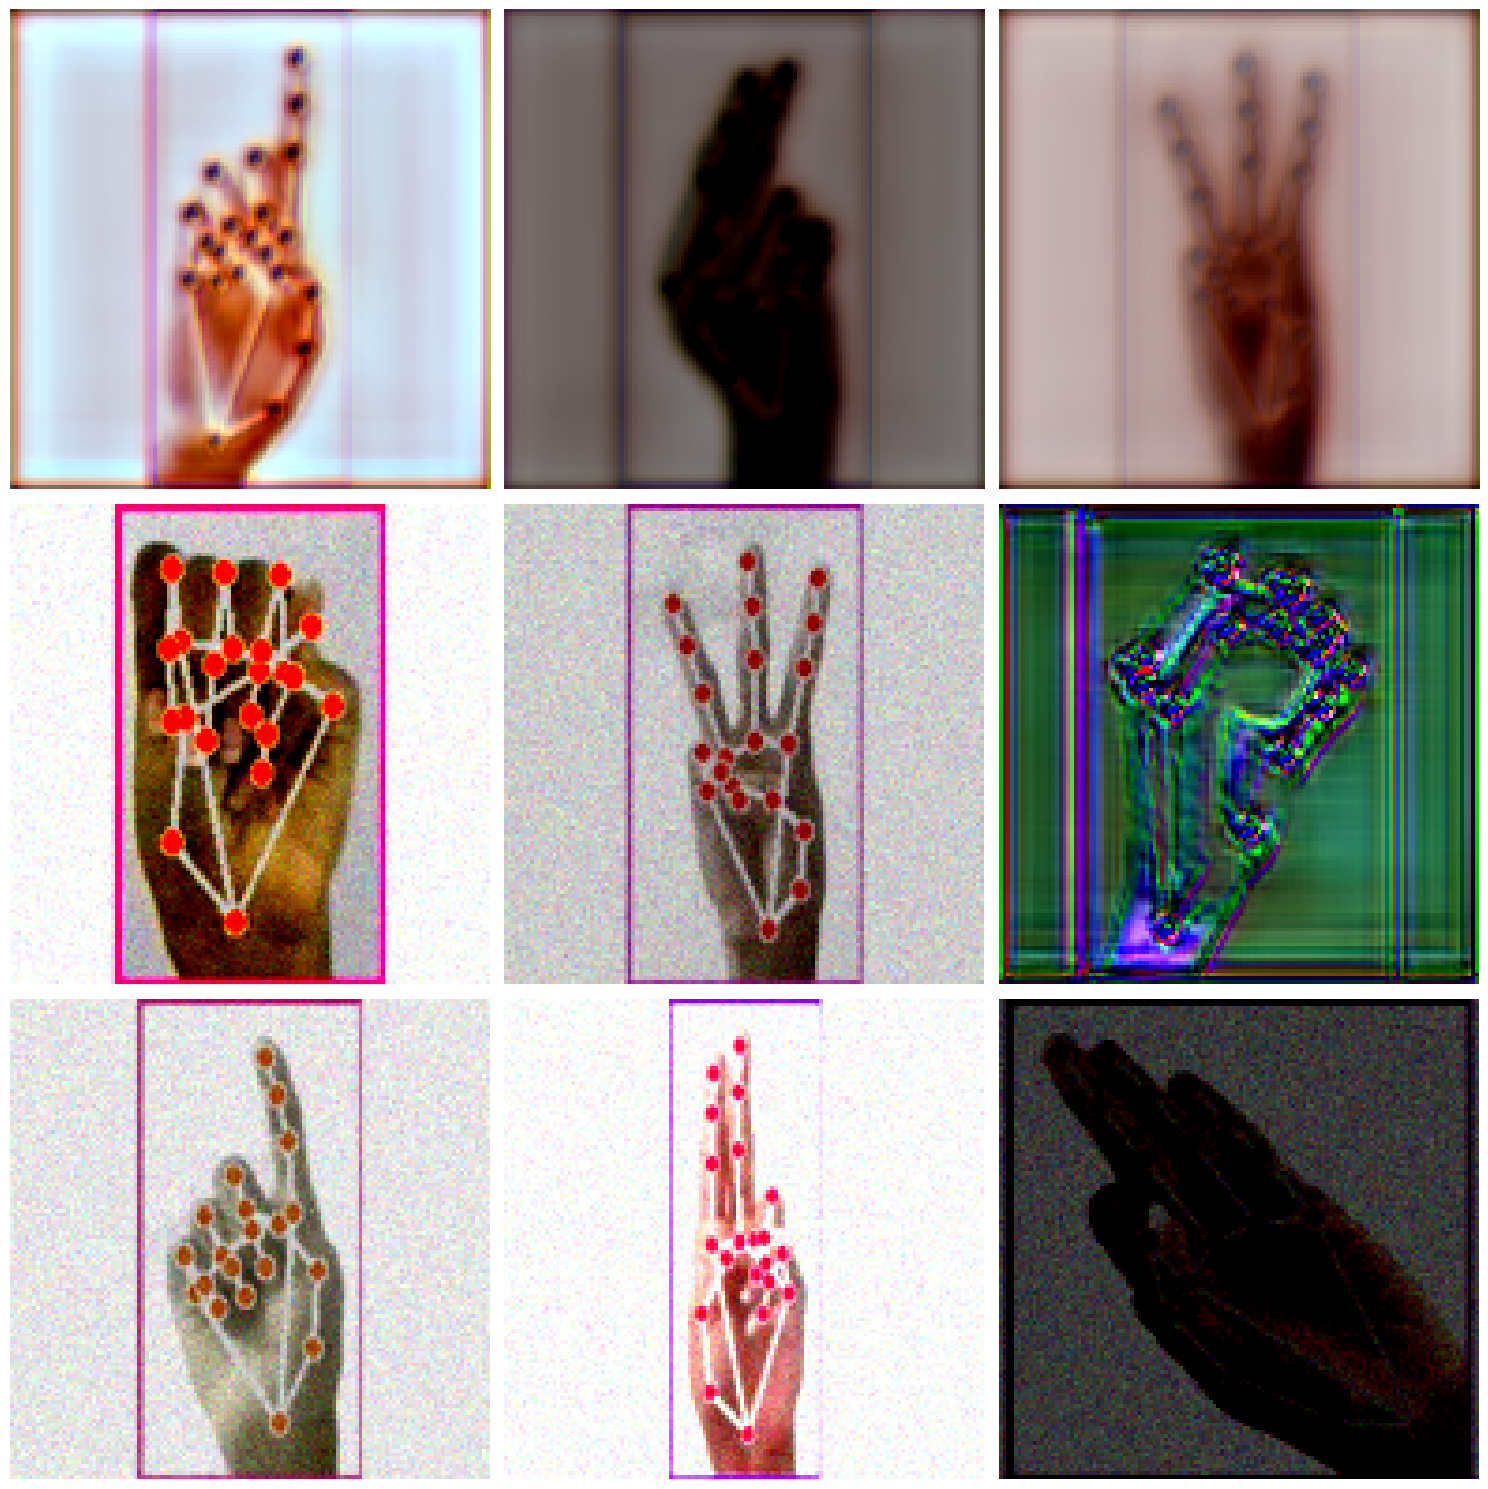

In [ ]:
import matplotlib.pyplot as plt

# Display multiple images in a grid
def display_images(image_paths, cols=3, rows=3):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    for ax, img_path in zip(axes.flatten(), image_paths):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get paths for a few generated images
image_paths = [os.path.join(output_dir, img) for img in generated_images[:24]]  # Adjust the number of images as needed
display_images(image_paths)